In [1]:
import pandas as pd
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Load your data
train_df = pd.read_csv('train.csv')

In [2]:
# Convert the 'date_time' column to a datetime format and set as index
train_df['date_time'] = pd.to_datetime(train_df['date_time'])
train_df.set_index('date_time', inplace=True)

# 1. Stationarity Check and Differencing
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    return result[1] <= 0.05

def make_stationary(df):
    diff_df = df.copy()
    # Consider only numeric columns
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    for col in numeric_cols:
        while not adf_test(diff_df[col]):
            diff_df[col] = diff_df[col].diff().dropna()
    return diff_df

stationary_df = make_stationary(train_df)

In [3]:
# 2. Determine Optimal Lag Order
stationary_numeric_df = stationary_df.select_dtypes(include=['float64', 'int64'])

model = VAR(stationary_numeric_df)
optimal_lags = 1

C:\Users\Nadim Pramono\PycharmProjects\pythonProject1\v392\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [4]:
# 3. Train the VAR Model
var_model = model.fit(optimal_lags)

In [6]:
# 4. Forecasting (For demonstration, forecasting the next 10 points)
forecast = var_model.forecast(stationary_numeric_df.values[-optimal_lags:], steps=10)

In [13]:
# Create forecast_df using columns from stationary_numeric_df
forecast_df = pd.DataFrame(forecast, columns=stationary_numeric_df.columns)
def invert_transformation(df, forecast_df, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    forecast_copy = forecast_df.copy()
    
    for col in forecast_df.columns:
        # Roll back 1st Diff
        forecast_copy[str(col)+'_forecast'] = df[col].iloc[-1] + forecast_copy[col].cumsum()
        
        # If second_diff is True, then we assume that the data was differenced twice
        # Hence, we'll need to roll back the 2nd differencing as well
        if second_diff:
            # First, get the 1st differenced data
            forecast_copy[str(col)+'_1d'] = df[col].iloc[-1] - df[col].iloc[-2] + forecast_copy[col].cumsum()
            # Then, roll back the 1st differencing to get to the original scale
            forecast_copy[str(col)+'_forecast'] = df[col].iloc[-1] + forecast_copy[str(col)+'_1d'].cumsum()
    
    return forecast_copy

forecast_inverted = invert_transformation(train_df, forecast_df)

In [15]:
# Only consider numeric columns from train_df for which we have forecasts
forecasted_columns = [col+'_forecast' for col in stationary_numeric_df.columns]

rmse = np.sqrt(mean_squared_error(train_df[stationary_numeric_df.columns].iloc[-10:], 
                                  forecast_inverted[forecasted_columns].iloc[-10:]))

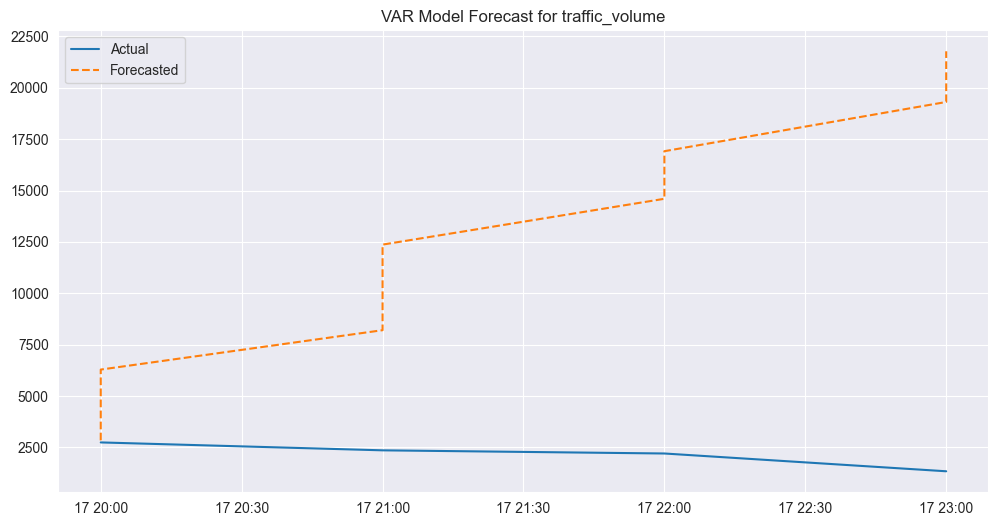

3534.2279972669644


In [17]:
# Choose a specific column for visualization, e.g., 'traffic_volume'
column_to_visualize = 'traffic_volume'

plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(train_df.index[-10:], train_df[column_to_visualize].iloc[-10:], label='Actual')

# Plot forecasted values
plt.plot(train_df.index[-10:], forecast_inverted[column_to_visualize + '_forecast'].iloc[-10:], 
         label='Forecasted', linestyle='--')

plt.legend()
plt.title(f'VAR Model Forecast for {column_to_visualize}')
plt.show()

print(rmse)